In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import torchbnn as bnn

In [11]:
creep_df = pd.read_csv('../PI_Data/PI_Ni_superalloys_dataset.csv')

# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep life'])
creep_df = creep_df.drop(['Creep life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature,log_creep_life
0,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1100.0,137.0,944.638367,3.026370
1,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796,3.009026
2,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796,2.969556
3,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677,2.957607
4,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655,2.939519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644,1.155336
148,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381,1.089905
149,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902,0.991226
150,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101,0.968483


In [12]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ni                152 non-null    float32
 1   Al                152 non-null    float32
 2   Co                152 non-null    float32
 3   Cr                152 non-null    float32
 4   Mo                152 non-null    float32
 5   Re                152 non-null    float32
 6   Ru                152 non-null    float32
 7   Ta                152 non-null    float32
 8   W                 152 non-null    float32
 9   Ti                152 non-null    float32
 10  Nb                152 non-null    float32
 11  T                 152 non-null    float32
 12  Stress            152 non-null    float32
 13  PI Creep Feature  152 non-null    float32
 14  log_creep_life    152 non-null    float32
dtypes: float32(15)
memory usage: 9.0 KB


In [13]:
# Extract features and targets
features = creep_df.iloc[:, 0:14]
targets = creep_df.iloc[:, 14]
features

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature
0,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,272.0,8.275208
1,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101
2,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902
3,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381
4,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655
148,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677
149,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796
150,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796


Run # 1 Fold # 1
MSE : 4.38, KL : 0.66
MSE : 0.02, KL : 0.70
MSE : 0.10, KL : 0.72
Pearson CC: 0.9708162953600867
R2 score: 0.941996387702916
RMSE: 0.08067978173494339
MAE: 0.06275679916143417
********************
Coverage: 99.99999999999994
Interval Width: 0.47612714767456055
Composite Metric: 1.2750698289753437


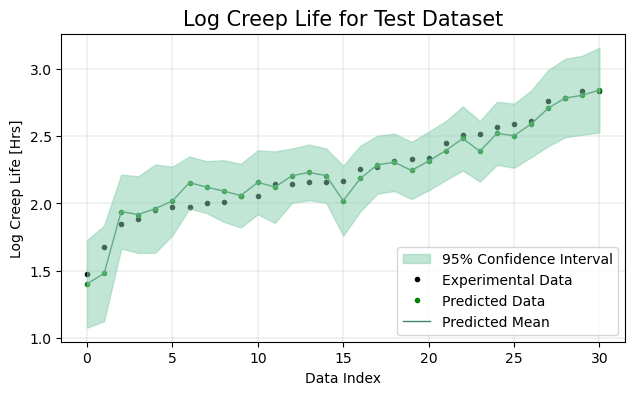

****************************************
Run # 1 Fold # 2
MSE : 5.17, KL : 0.65
MSE : 0.02, KL : 0.69
MSE : 0.03, KL : 0.70
Pearson CC: 0.9725960314174762
R2 score: 0.920825586101523
RMSE: 0.12664122879505157
MAE: 0.09585779905319214
********************
Coverage: 96.77419354838705
Interval Width: 0.4990968704223633
Composite Metric: 1.2267112154284647


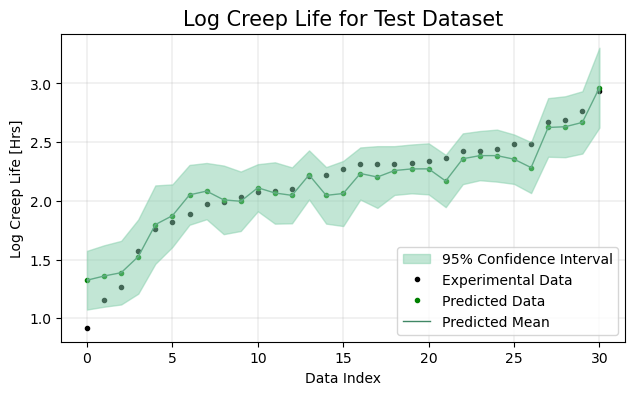

****************************************
Run # 1 Fold # 3
MSE : 4.57, KL : 0.65
MSE : 0.02, KL : 0.69
MSE : 0.02, KL : 0.71
Pearson CC: 0.971424054819789
R2 score: 0.942606824578027
RMSE: 0.11405348032712936
MAE: 0.08079927414655685
********************
Coverage: 96.66666666666664
Interval Width: 0.5154978036880493
Composite Metric: 1.2099681186057702


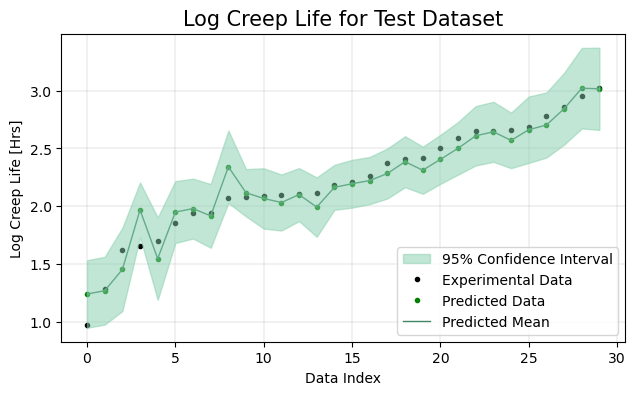

****************************************
Run # 1 Fold # 4
MSE : 4.49, KL : 0.65
MSE : 0.04, KL : 0.69
MSE : 0.05, KL : 0.71
Pearson CC: 0.9594662687588336
R2 score: 0.9063562698625445
RMSE: 0.10459928959608078
MAE: 0.07311355322599411
********************
Coverage: 93.33333333333331
Interval Width: 0.423295259475708
Composite Metric: 1.2906042990173079


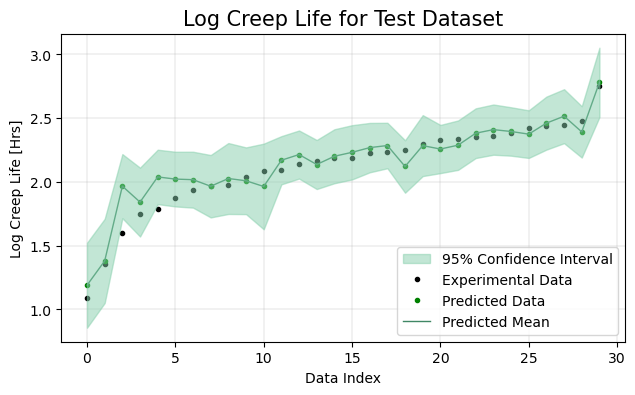

****************************************
Run # 1 Fold # 5
MSE : 4.48, KL : 0.66
MSE : 0.09, KL : 0.70
MSE : 0.02, KL : 0.72
Pearson CC: 0.9734486043554964
R2 score: 0.9425970335373376
RMSE: 0.09243364632129669
MAE: 0.07135416567325592
********************
Coverage: 99.99999999999997
Interval Width: 0.45894503593444824
Composite Metric: 1.2947275390853288


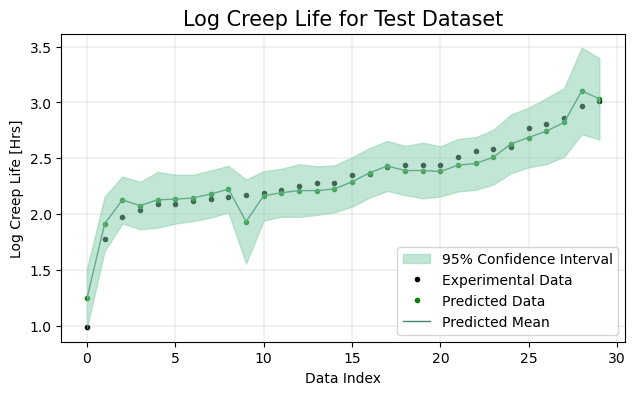

****************************************


In [14]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)
            y_train = torch.unsqueeze(y_train, dim=1)
            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)
            y_test = torch.unsqueeze(y_test, dim=1)

            # create pytorch dataset class
            class MyDataset(Dataset):
                def __init__(self, train_data, train_targets):
                    self.train_features = train_data
                    self.train_labels = train_targets

                def __len__(self):
                    return self.train_features.shape[0]

                def __getitem__(self, idx):
                    feature = self.train_features[idx]
                    label = self.train_labels[idx]

                    return feature, label

            train_dataset = train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
            model = nn.Sequential(
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=14, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=1),
            )

            # define the loss function and optimizer
            mse_loss = nn.MSELoss()
            kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            kl_weight = 0.01

            optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.95)
            for step in range(3000):
                  for n, data in enumerate(train_dataloader):
                        traning_data, training_label = data


                        y_pred = model(traning_data)
                        mse = mse_loss(y_pred, training_label)
                        kl = kl_loss(model)
                        cost = mse + kl_weight*kl

                        optimizer.zero_grad()
                        cost.backward()
                        optimizer.step()

                  if step % 1000==0:
                        print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
            y_pred_test = model(x_test)

            # inference
            n_samples = 1000

            # compute predictions
            y_preds = [model(x_test).clone().detach().numpy() for _ in range(n_samples)]
            y_preds = np.array(y_preds)
            # mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(40*'*')

In [15]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.970816,0.941996,0.080680,0.062757
1,0.972596,0.920826,0.126641,0.095858
2,0.971424,0.942607,0.114053,0.080799
3,0.959466,0.906356,0.104599,0.073114
4,0.973449,0.942597,0.092434,0.071354


In [16]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.96955,0.005124,0.930876,0.014838,0.103681,0.01607,0.076776,0.011132


In [17]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,100.000000,0.476127,1.275070
1,96.774194,0.499097,1.226711
2,96.666667,0.515498,1.209968
3,93.333333,0.423295,1.290604
4,100.000000,0.458945,1.294728


In [18]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,97.354839,2.489056,0.474592,0.032101,1.259416,0.034581
